# Single-cell RNA-seq analysis workflow using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION. 

Licensed under the Apache License, Version 2.0 (the "License") 
you may not use this file except in compliance with the License. 
You may obtain a copy of the License at 

     http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software 
distributed under the License is distributed on an "AS IS" BASIS, 
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 
See the License for the specific language governing permissions and 
limitations under the License.

In [1]:
%load_ext gofigr
from gofigr.jupyter import *
configure(analysis=FindByName("RAPIDS", create=True))

<IPython.core.display.Javascript object>

## Import requirements

In [2]:
import time

import numpy as np
import scanpy as sc

import os, wget

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [3]:
# Add path to input file here.
input_file = "../data/krasnow_hlca_10x.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/krasnow_hlca_10x.sparse.h5ad',
                  input_file)

## Set parameters

In [4]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this 
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc.settings.n_jobs=16

In [5]:
start = time.time()

## Load Data

In [6]:
%%time
adata = sc.read(input_file)

CPU times: user 124 ms, sys: 160 ms, total: 283 ms
Wall time: 283 ms


## Preprocessing

In [7]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 1.03 s, sys: 487 ms, total: 1.52 s
Wall time: 1.52 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

CPU times: user 902 ms, sys: 247 ms, total: 1.15 s
Wall time: 1.15 s


### Normalize

In [10]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 300 ms, sys: 47.9 ms, total: 348 ms
Wall time: 347 ms


In [11]:
%%time
sc.pp.log1p(adata)

CPU times: user 1.46 s, sys: 793 µs, total: 1.46 s
Wall time: 1.46 s


### Select Most Variable Genes

In [12]:
%%time
# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker+"_raw"]= adata.X[:, adata.var.index==marker].toarray()

adata = adata.copy()
n_genes = sum(adata.var.highly_variable)

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 1.27 s, sys: 67.4 ms, total: 1.34 s
Wall time: 1.34 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

In [13]:
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [14]:
%%time
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_ribo'] = np.array(np.sum(adata[:, ribo_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 1.02 s, sys: 41.8 ms, total: 1.06 s
Wall time: 1.06 s


In [15]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_ribo'], n_jobs=1)

CPU times: user 6min 14s, sys: 19min 25s, total: 25min 40s
Wall time: 3min 14s


### Scale

In [16]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.58 s, sys: 113 ms, total: 1.69 s
Wall time: 1.69 s


In [17]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 202.85558223724365


## Cluster & Visualize

### Reduce

In [18]:
%%time
# PCA
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 1min 3s, sys: 53.2 s, total: 1min 56s
Wall time: 15.5 s


### TSNE + K-means

In [19]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs)

CPU times: user 18min 16s, sys: 2min 31s, total: 20min 47s
Wall time: 3min 45s


In [20]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 35.2 s, sys: 24.3 s, total: 59.5 s
Wall time: 7.51 s


... storing 'kmeans' as categorical


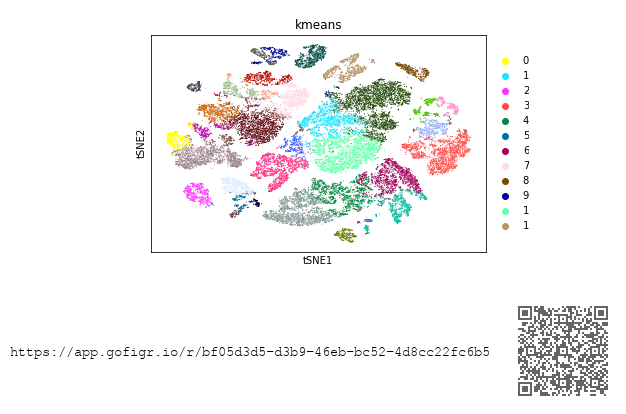


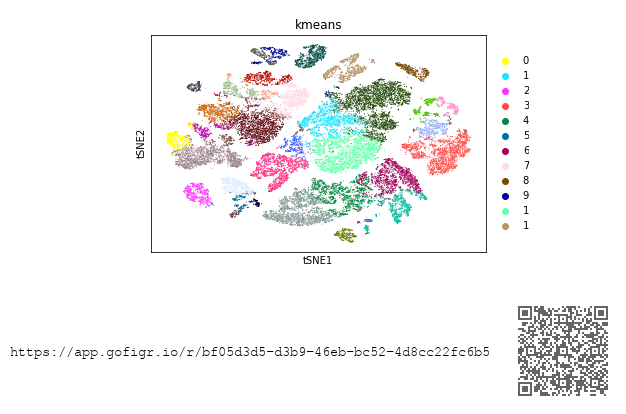
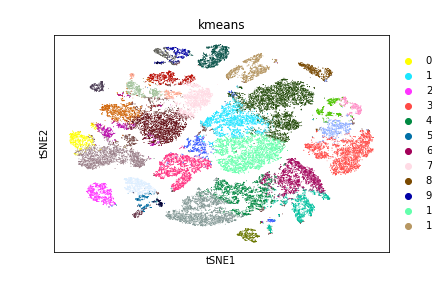
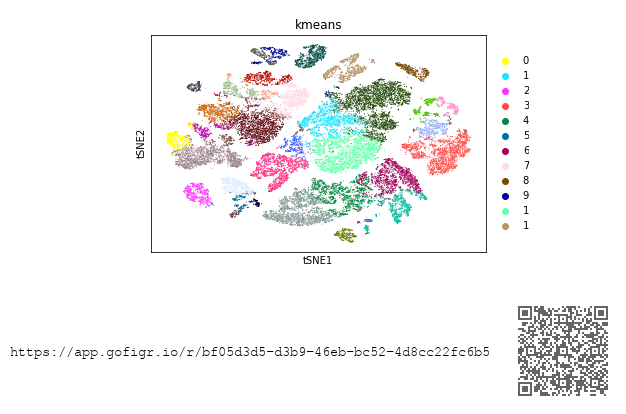
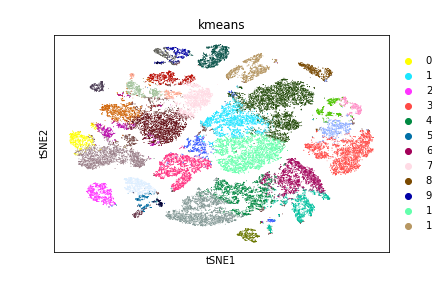

CPU times: user 6.53 s, sys: 139 ms, total: 6.67 s
Wall time: 10.6 s


In [21]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

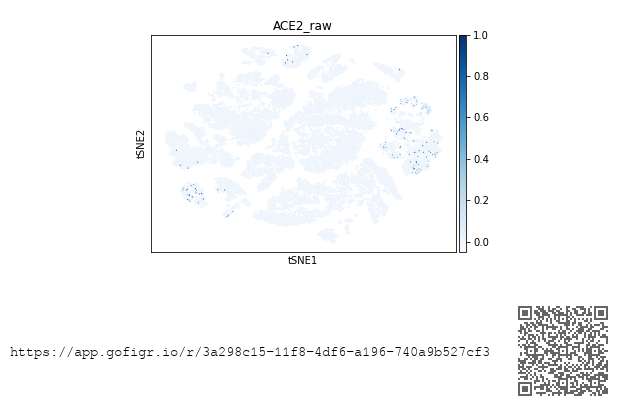


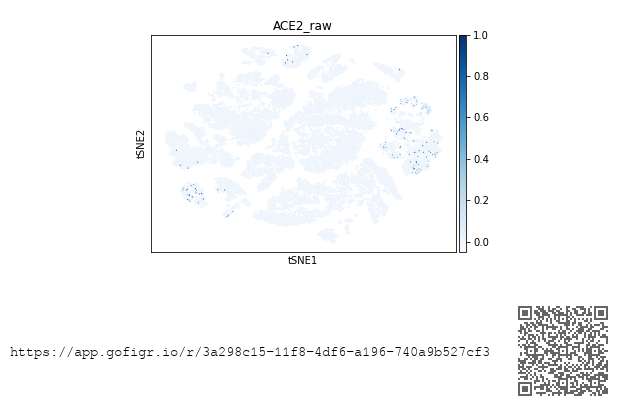
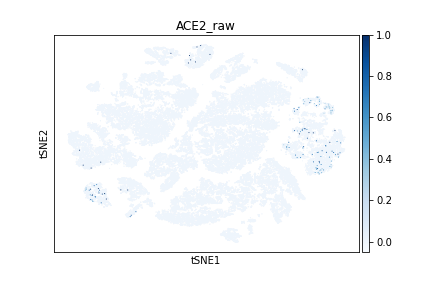
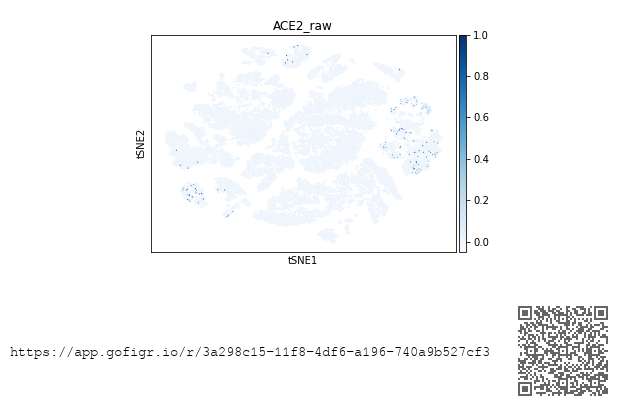
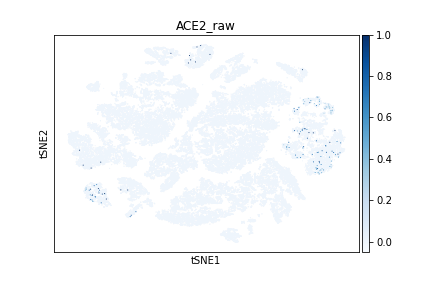

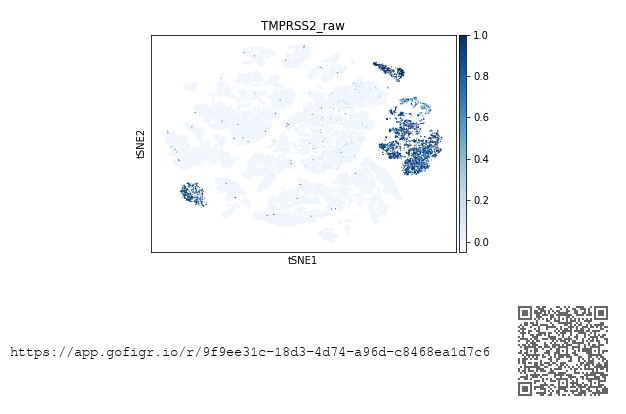


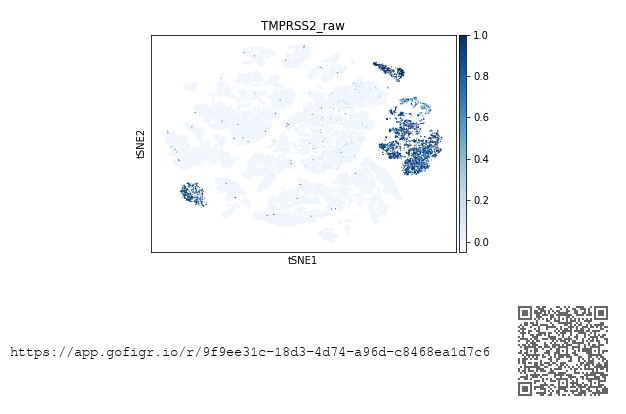
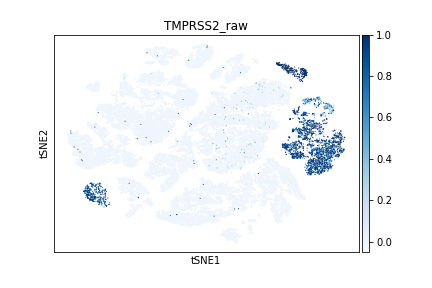
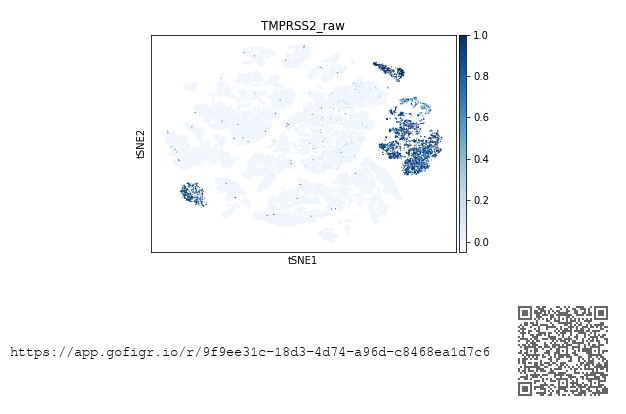
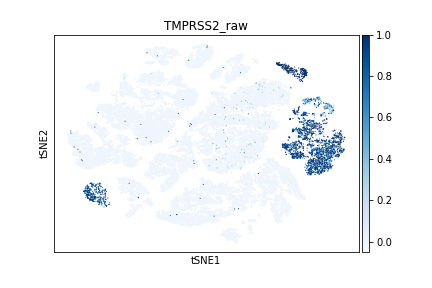

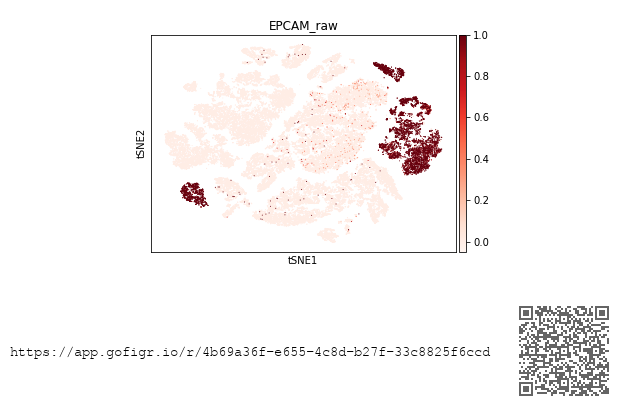


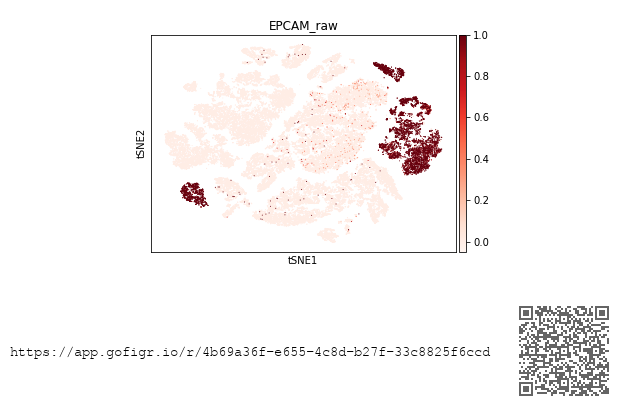
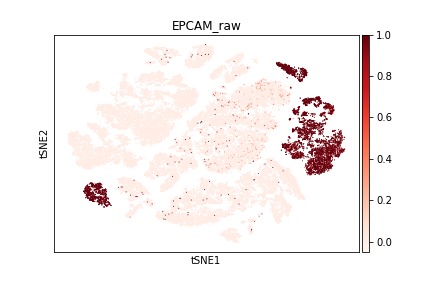
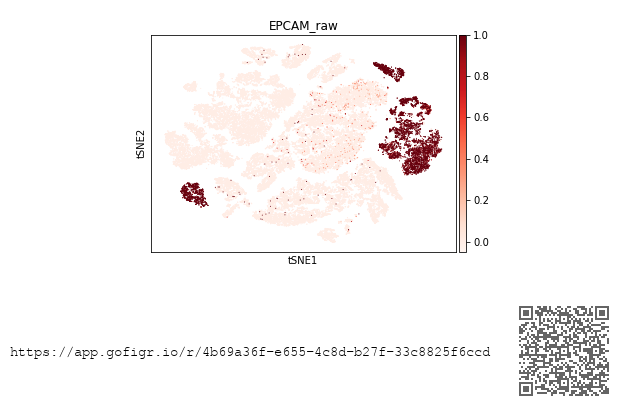
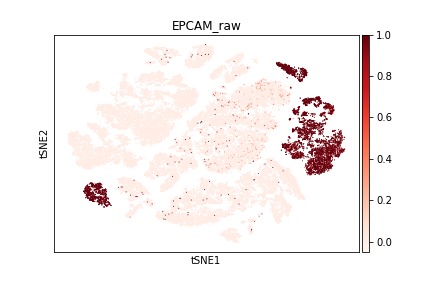

CPU times: user 15.7 s, sys: 148 ms, total: 15.8 s
Wall time: 25.6 s


In [22]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Graph clustering

In [23]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 15.3 s, sys: 1.64 s, total: 17 s
Wall time: 10.4 s


In [24]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 2min 22s, sys: 27.2 s, total: 2min 50s
Wall time: 1min 5s


In [25]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 9.19 s, sys: 82.6 ms, total: 9.28 s
Wall time: 9.26 s


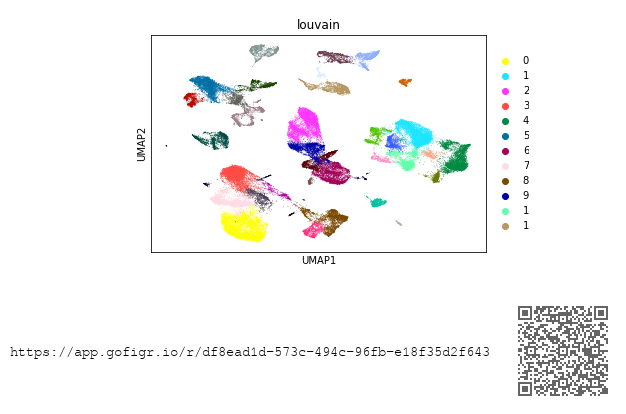


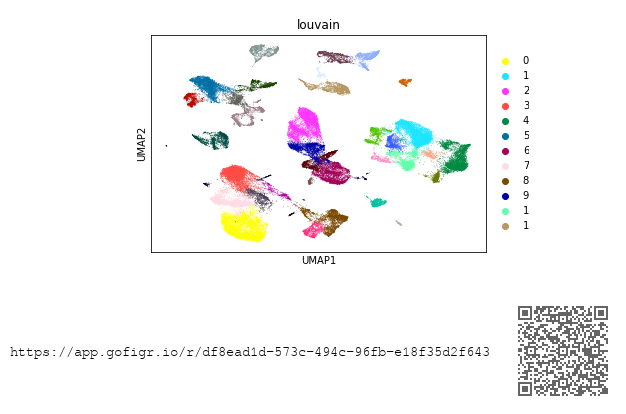
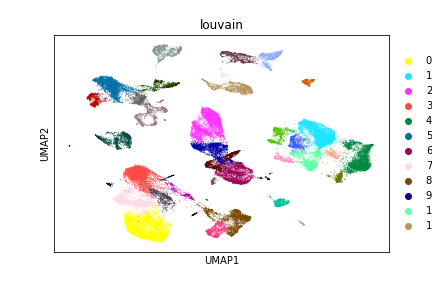
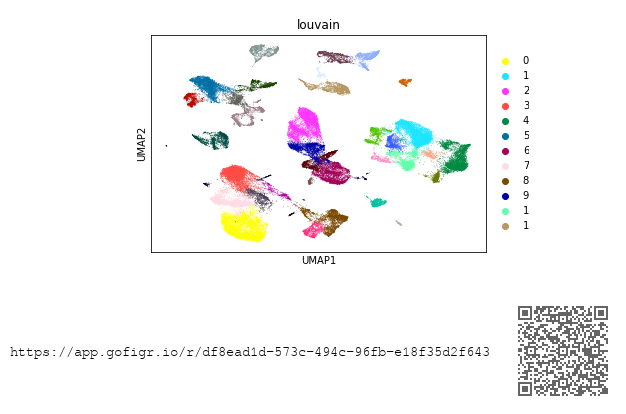
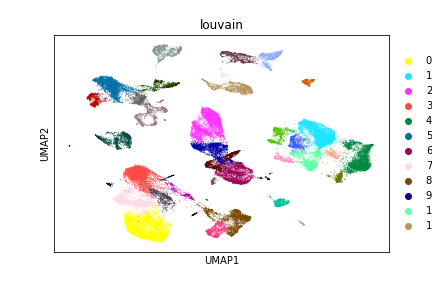

CPU times: user 6.46 s, sys: 55.7 ms, total: 6.52 s
Wall time: 10 s


In [26]:
%%time
# Plot
sc.pl.umap(adata, color=["louvain"])

In [27]:
!pip install leidenalg

In [28]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 31.7 s, sys: 114 ms, total: 31.9 s
Wall time: 31.8 s


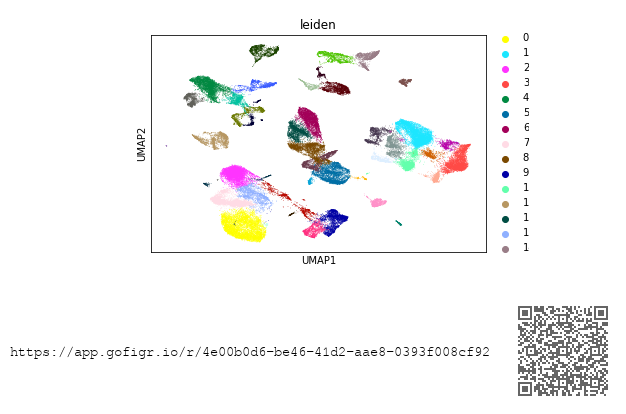


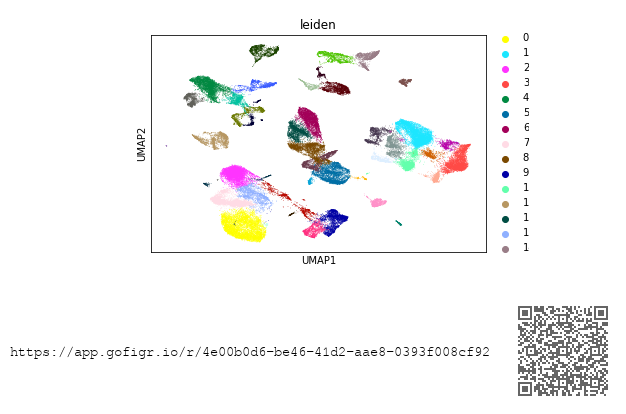
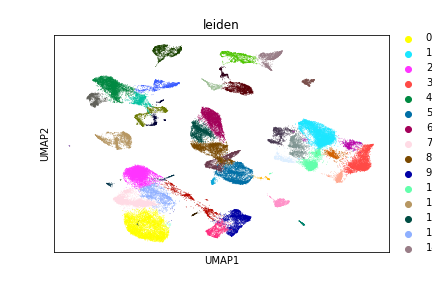
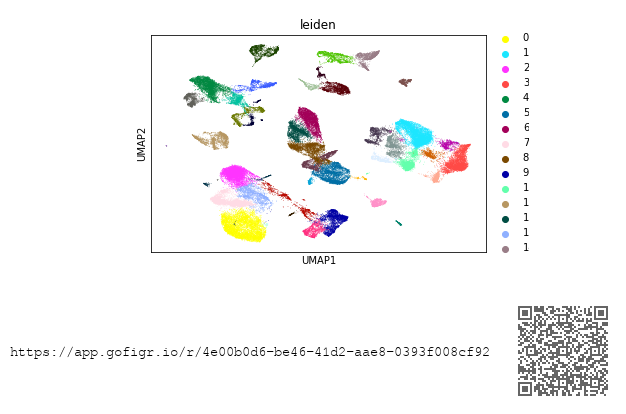
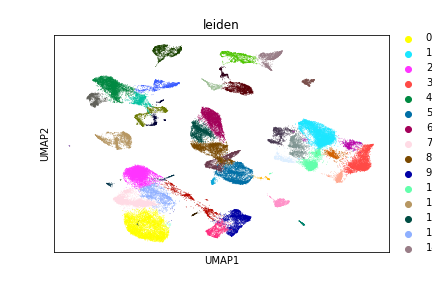

CPU times: user 6.62 s, sys: 61.2 ms, total: 6.68 s
Wall time: 10 s


In [29]:
%%time
# Plot
sc.pl.umap(adata, color=["leiden"])

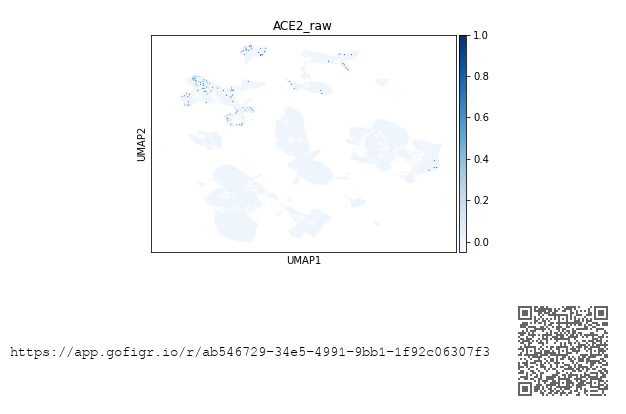


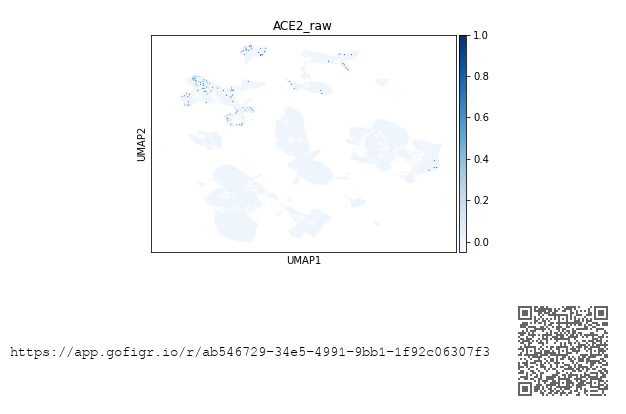
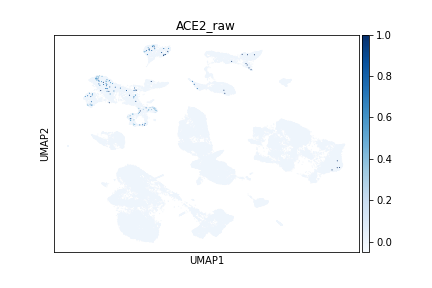
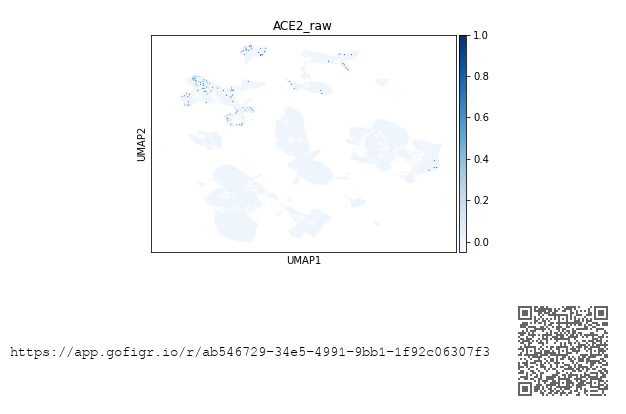
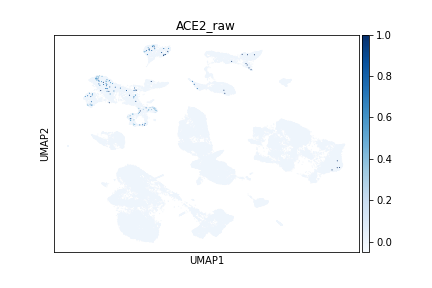

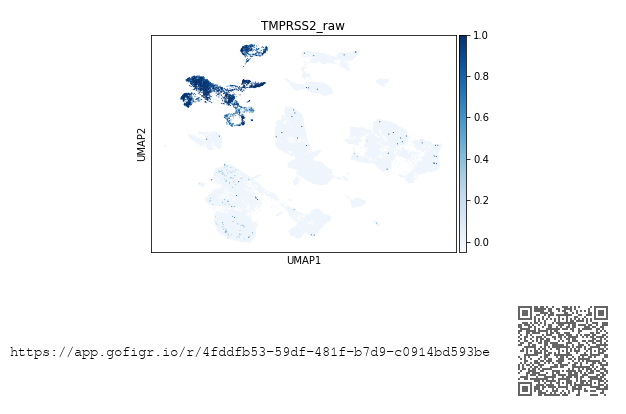


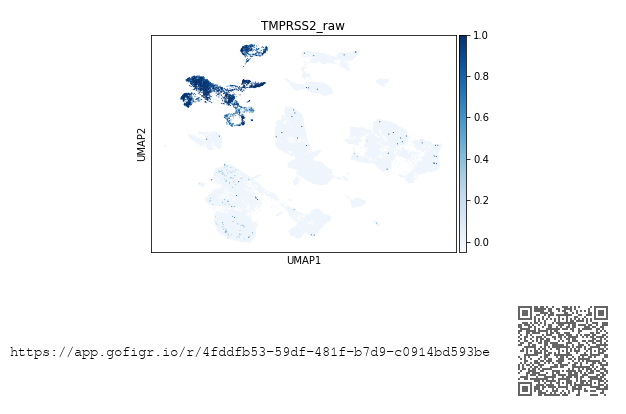
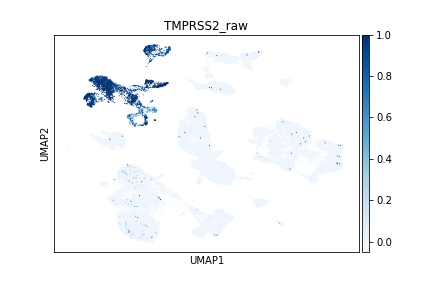
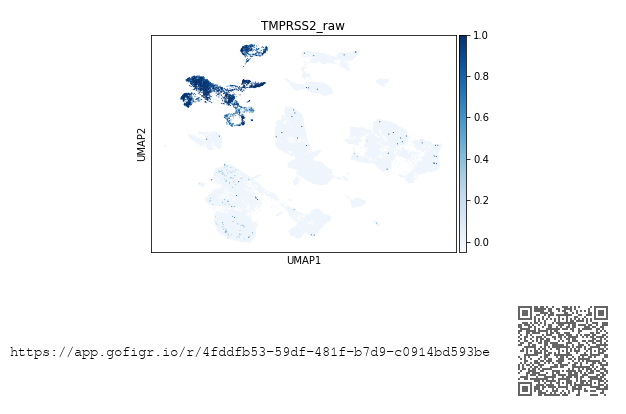
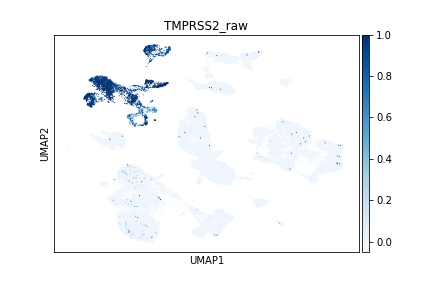

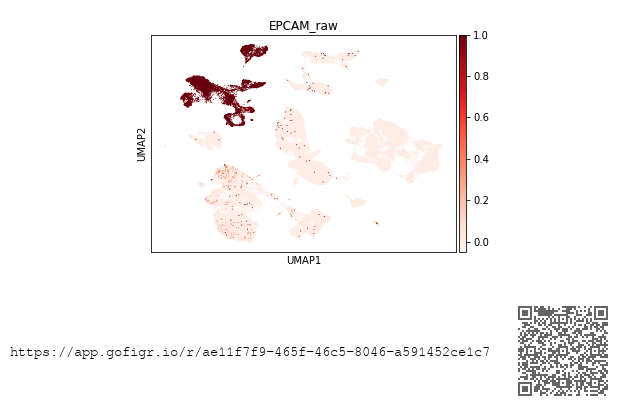


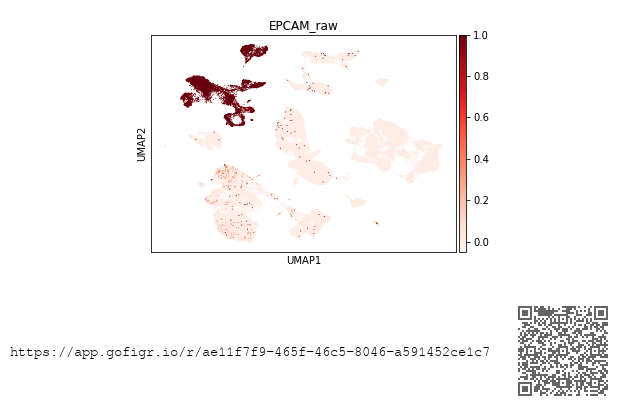
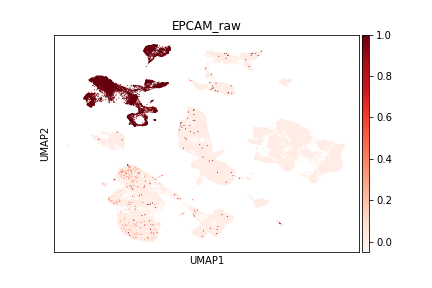
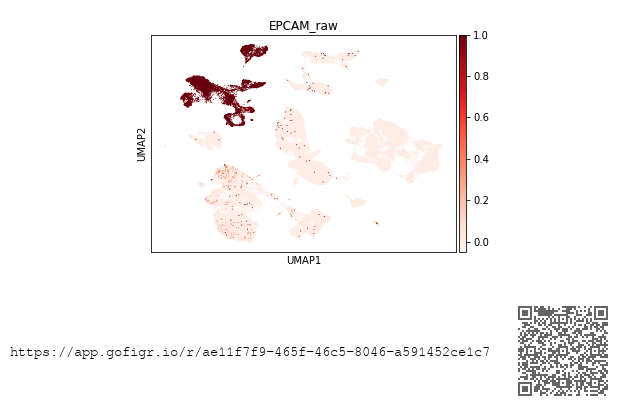
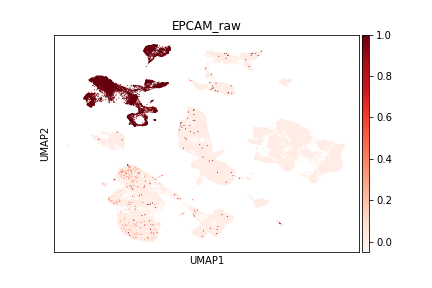

CPU times: user 15.5 s, sys: 179 ms, total: 15.7 s
Wall time: 25.5 s


In [30]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

## Differential expression analysis

In [31]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=ranking_n_top_genes, groups='all', reference='rest', method='logreg', n_jobs=1)

CPU times: user 17min 22s, sys: 4min 45s, total: 22min 8s
Wall time: 2min 47s


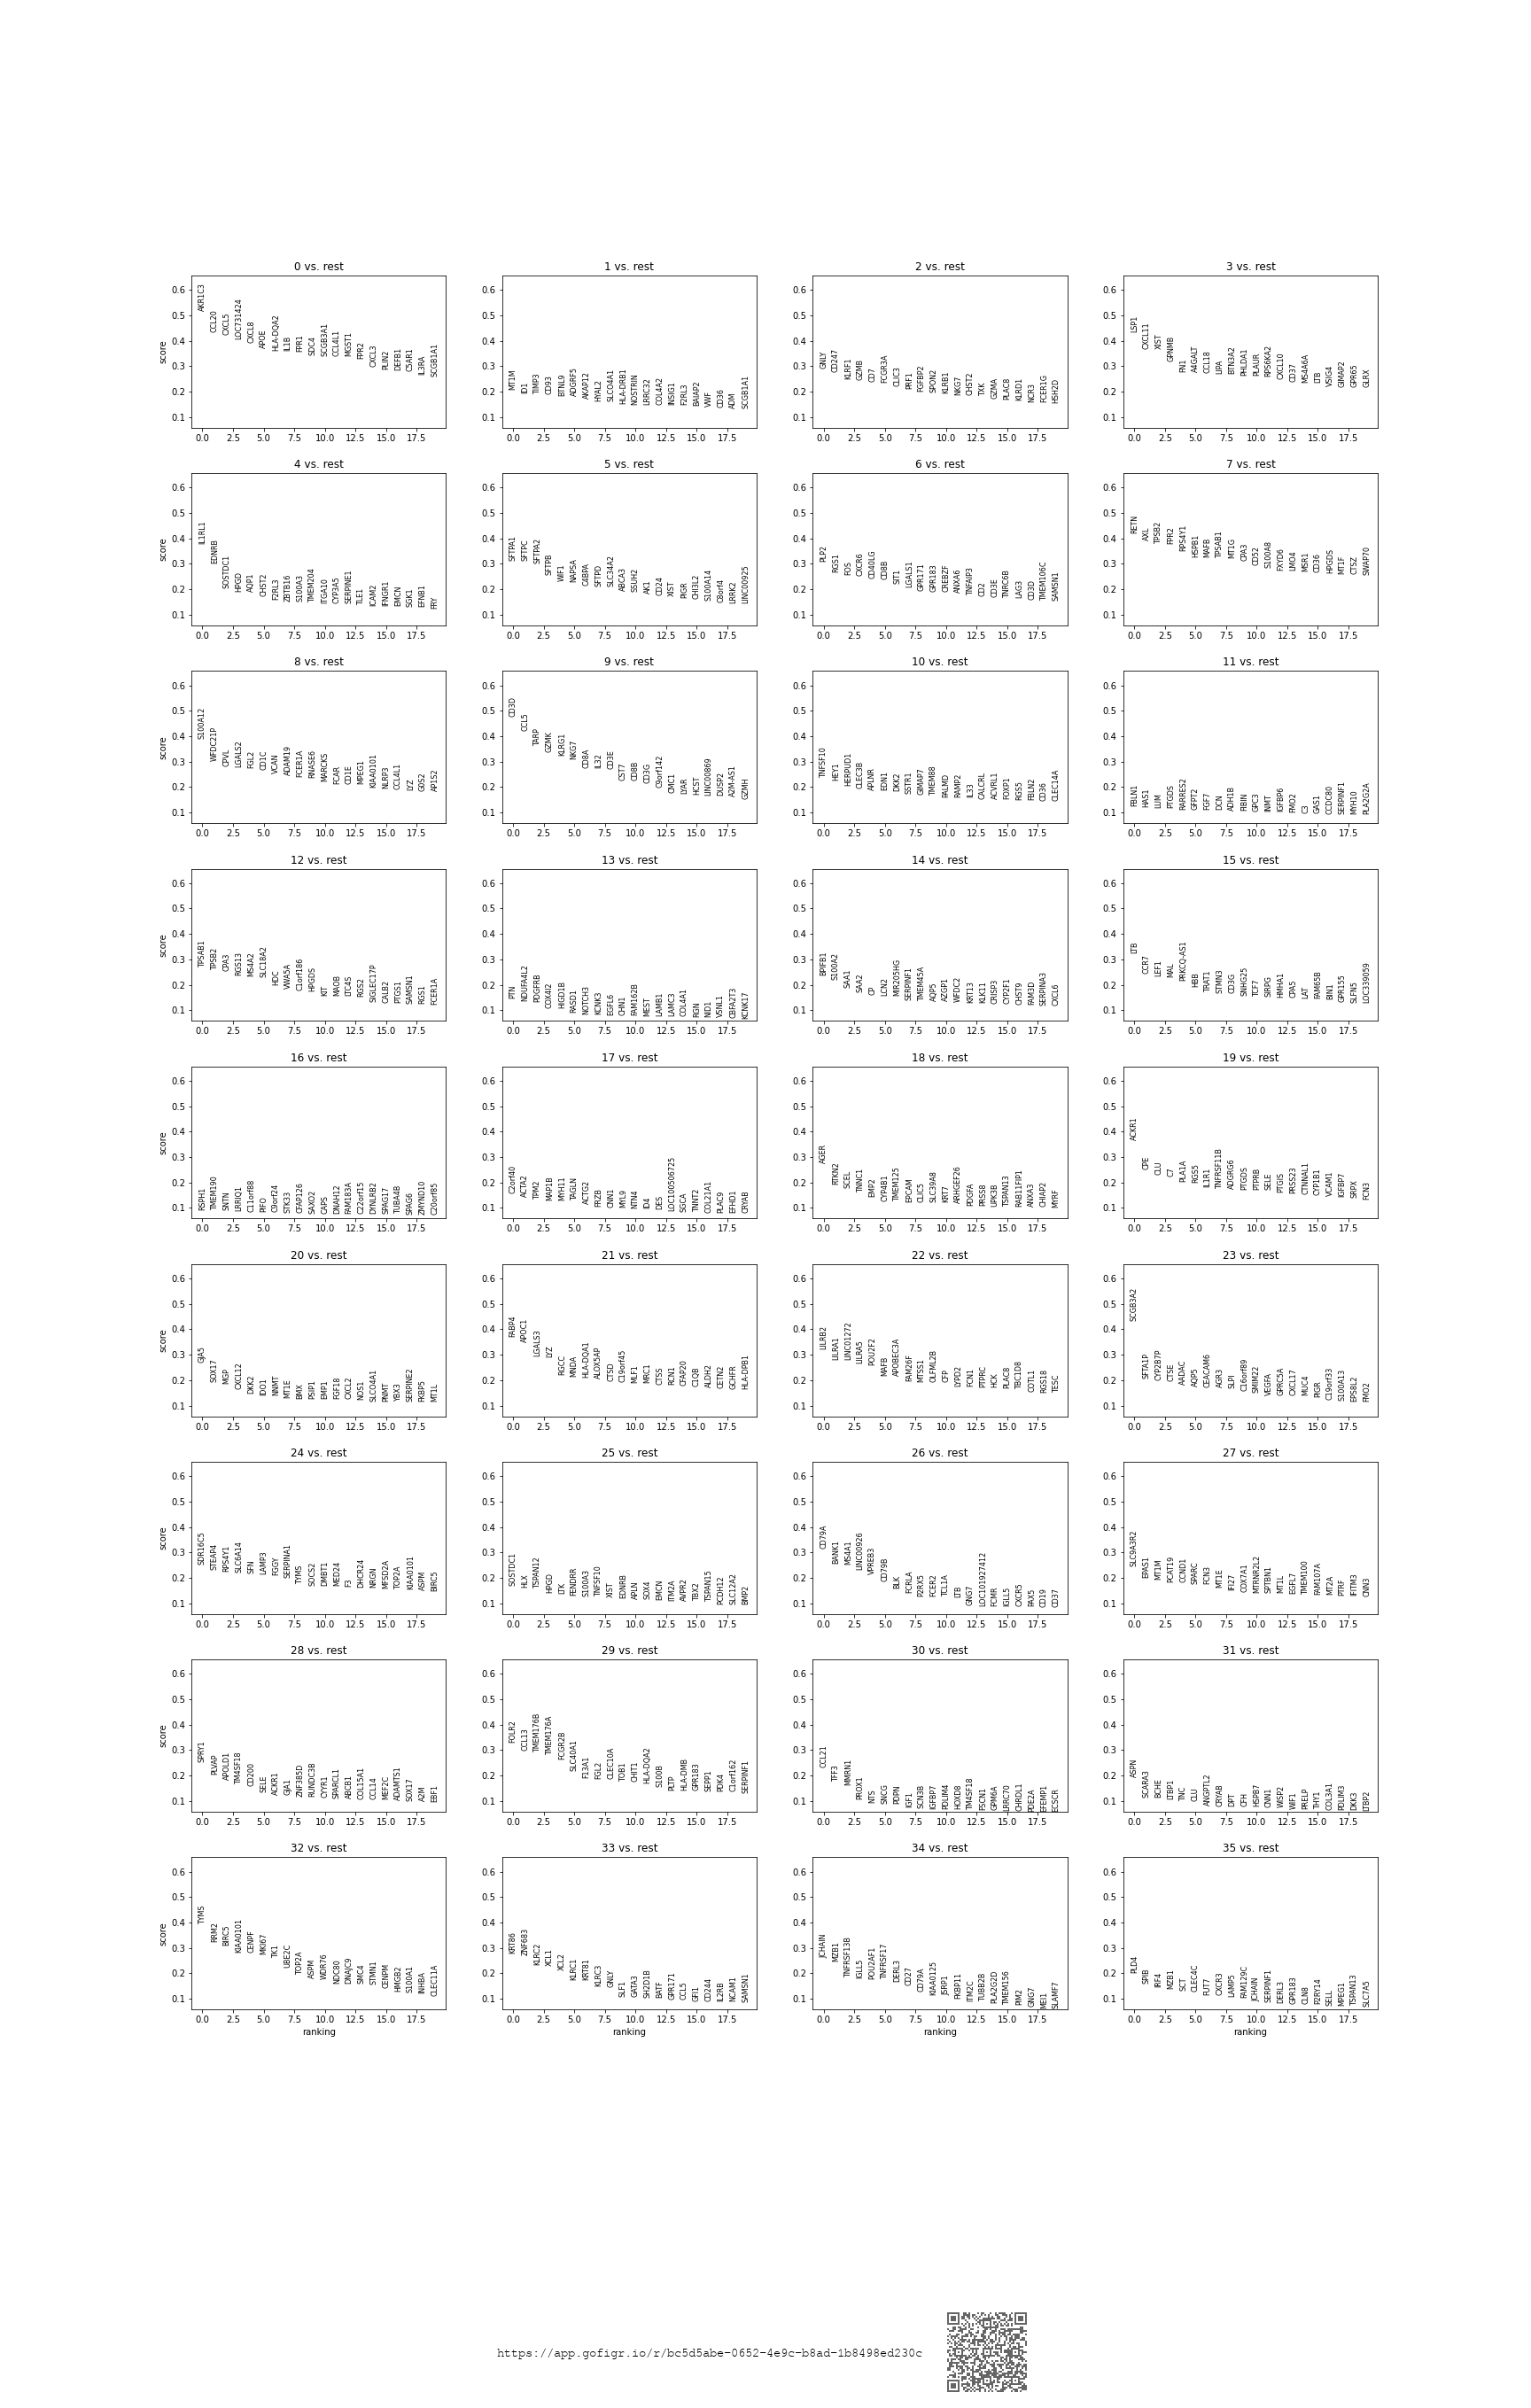


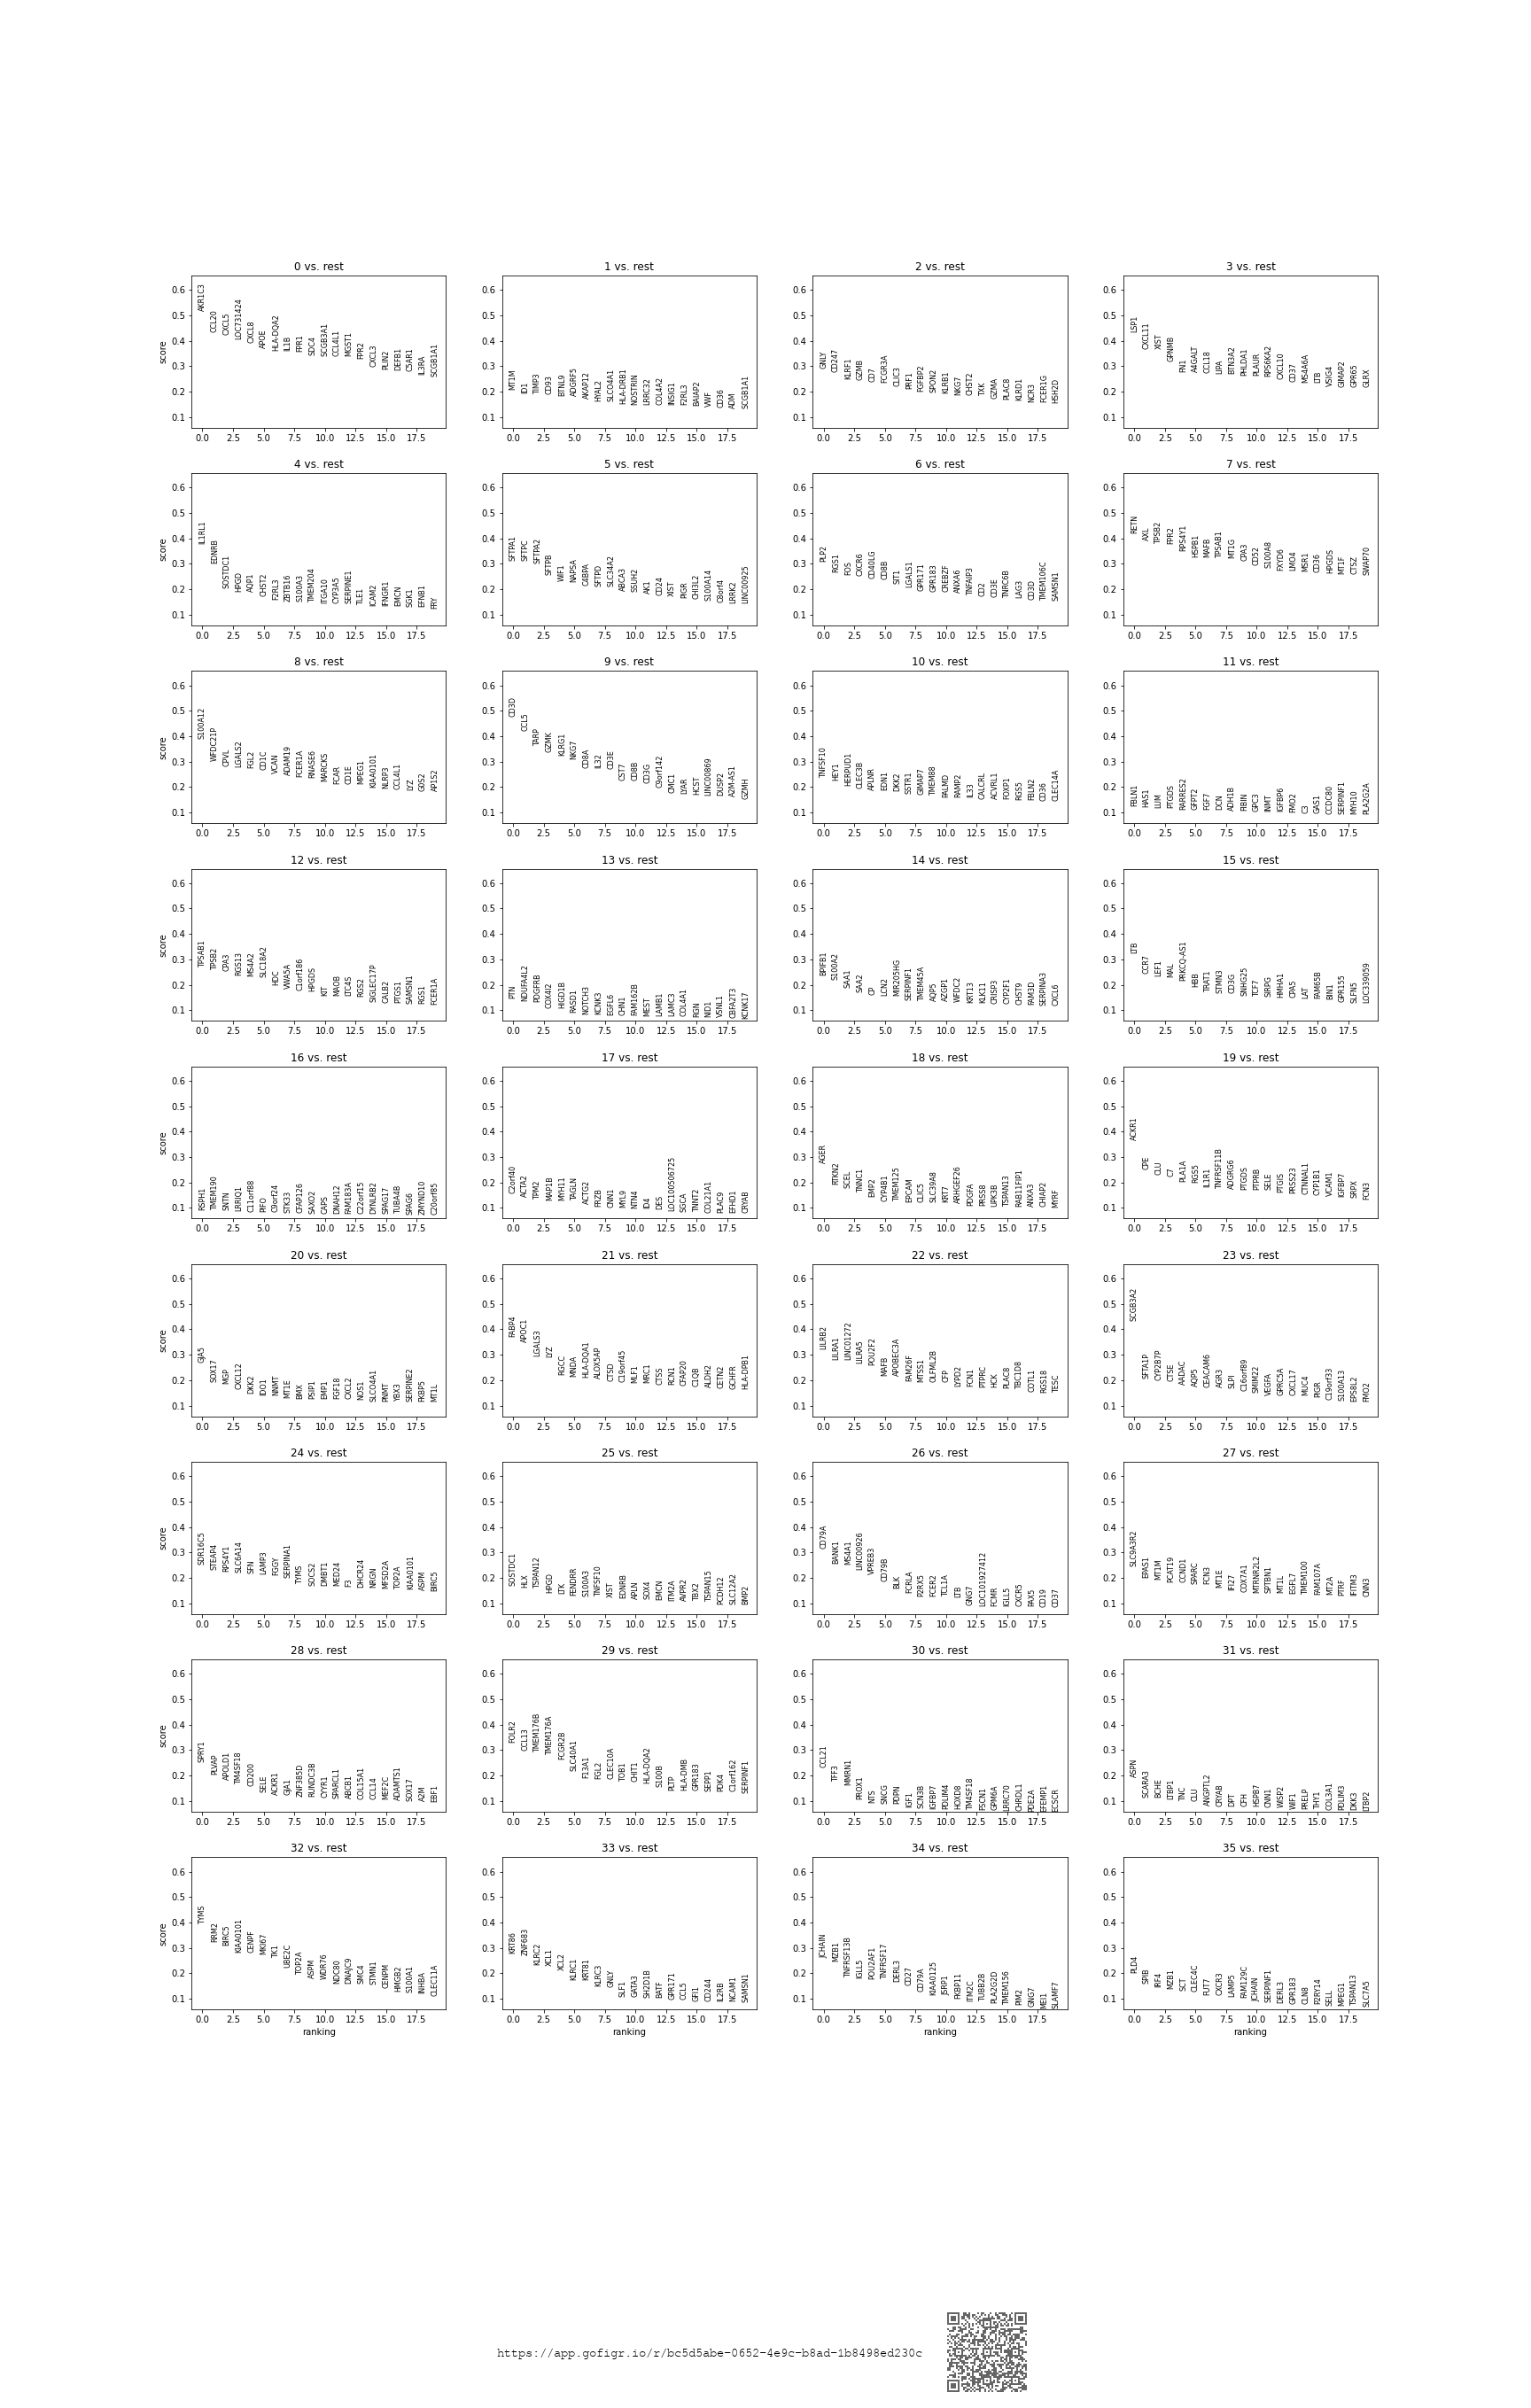
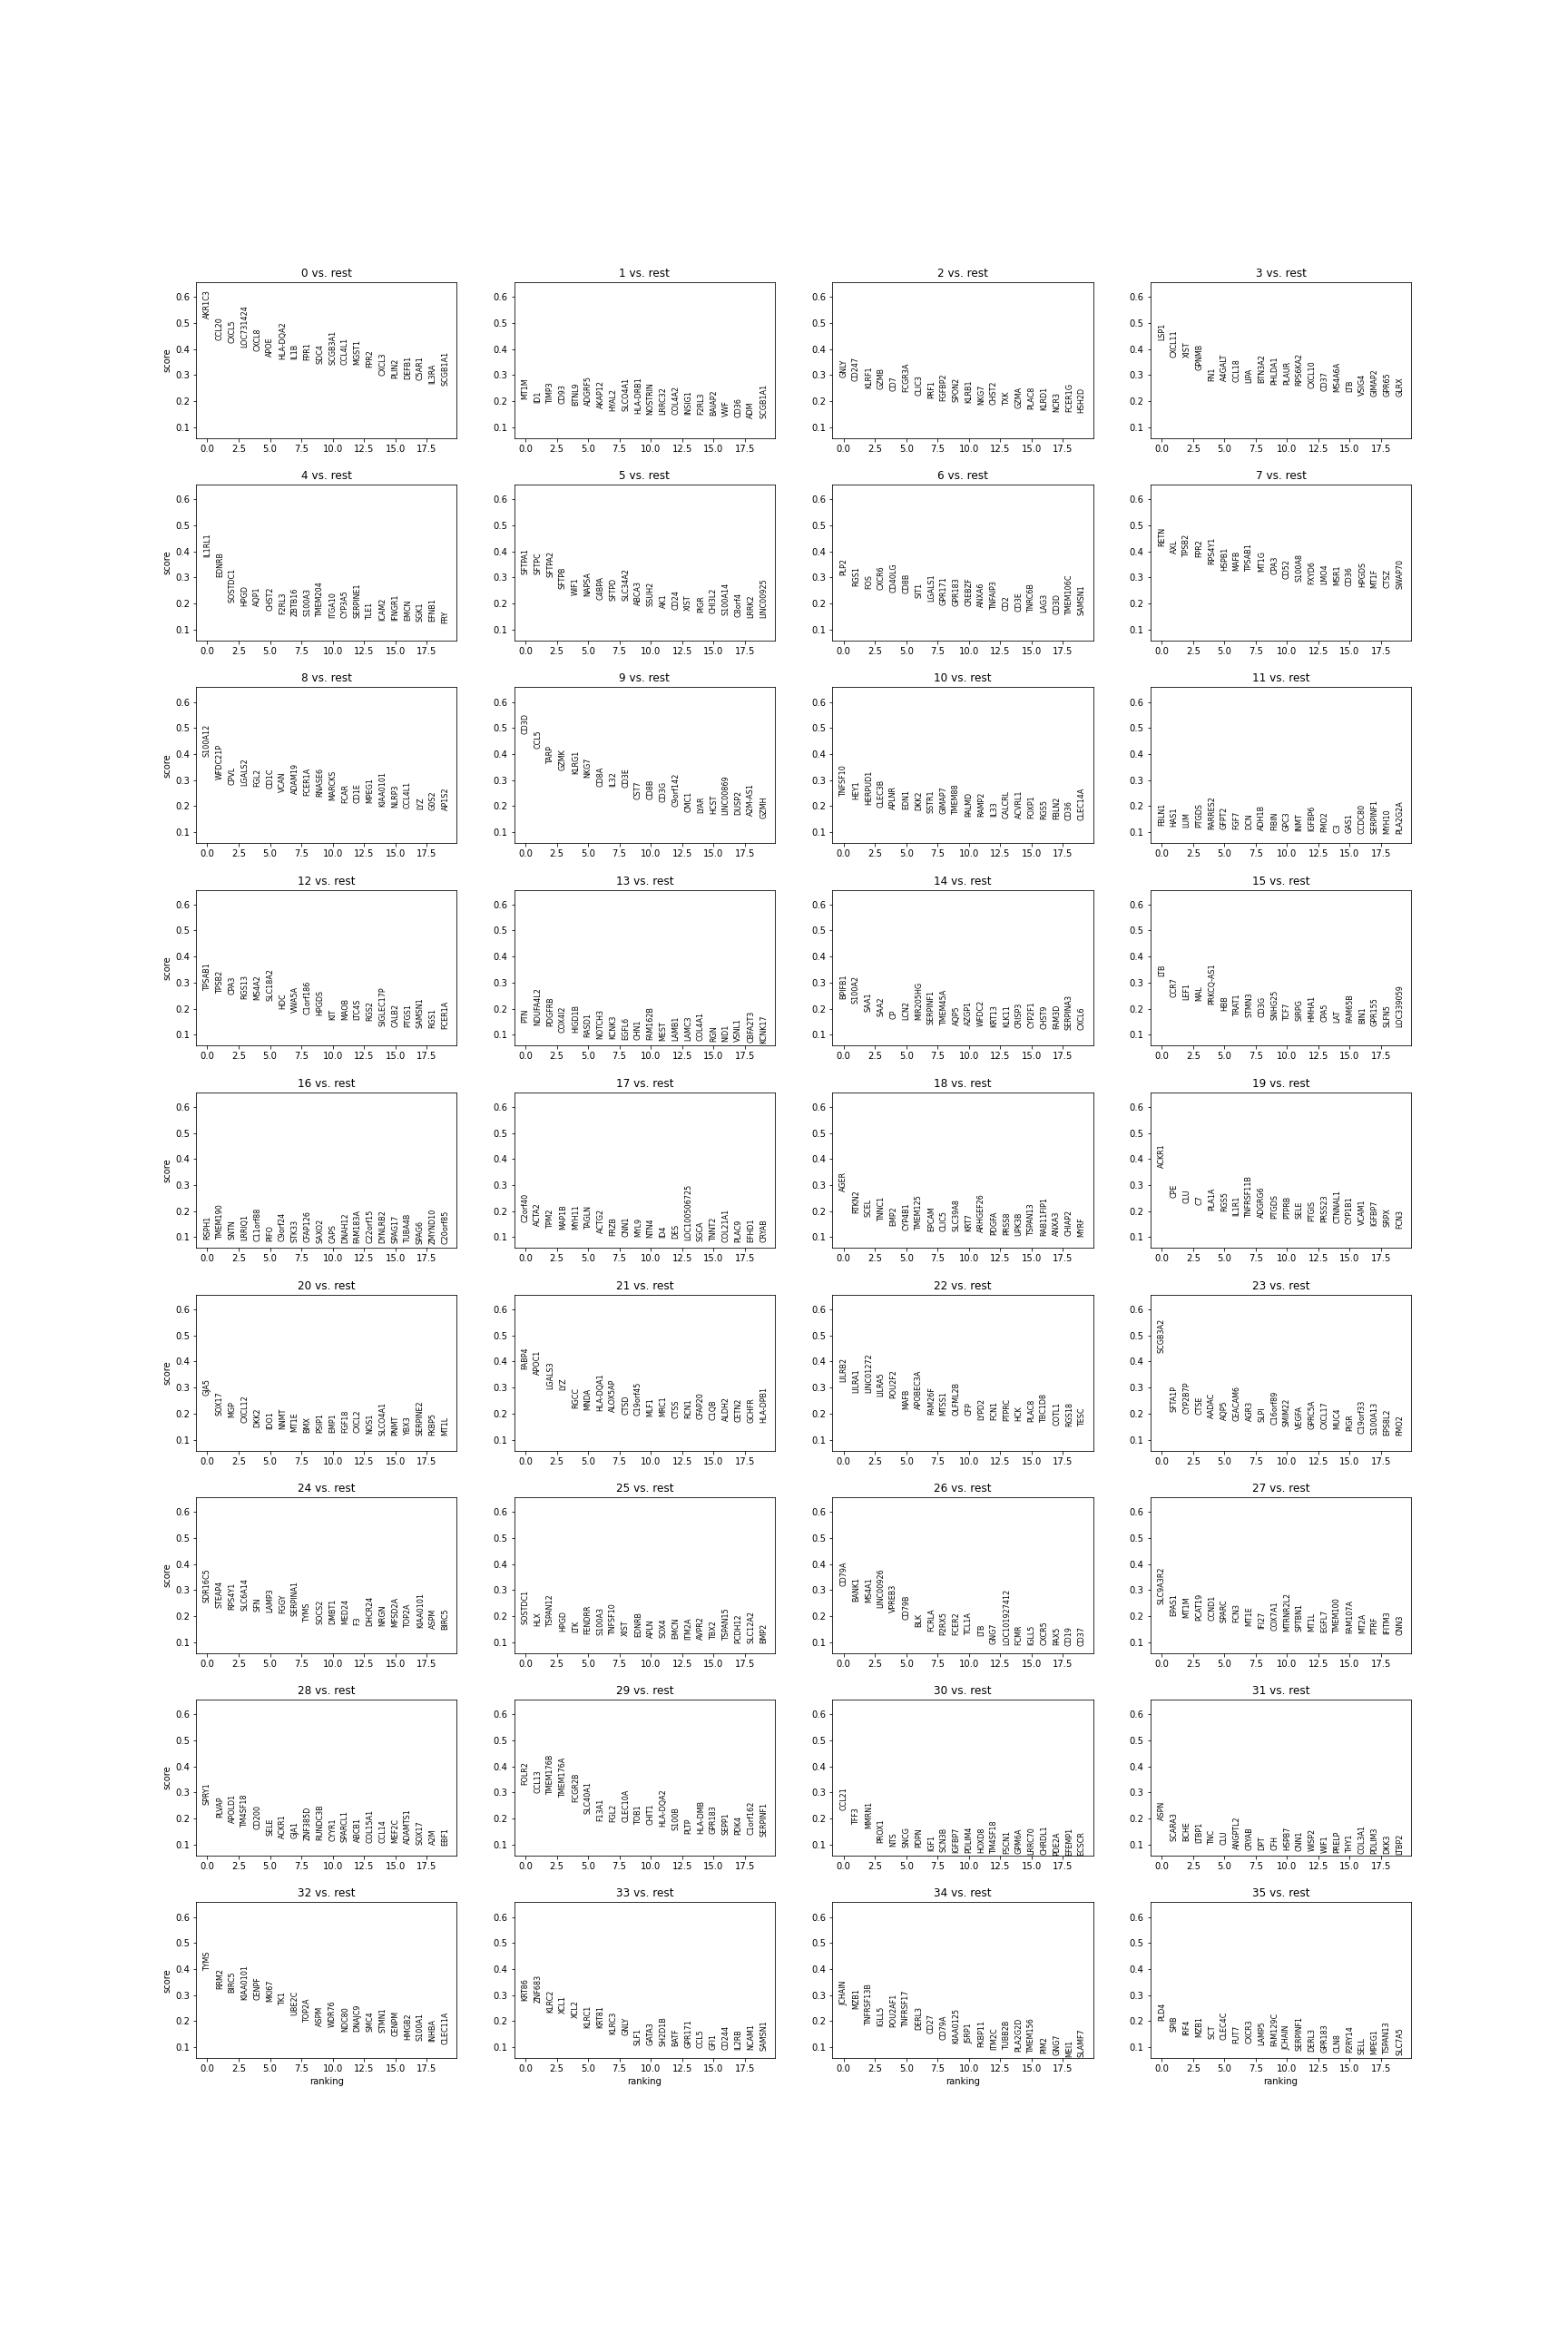
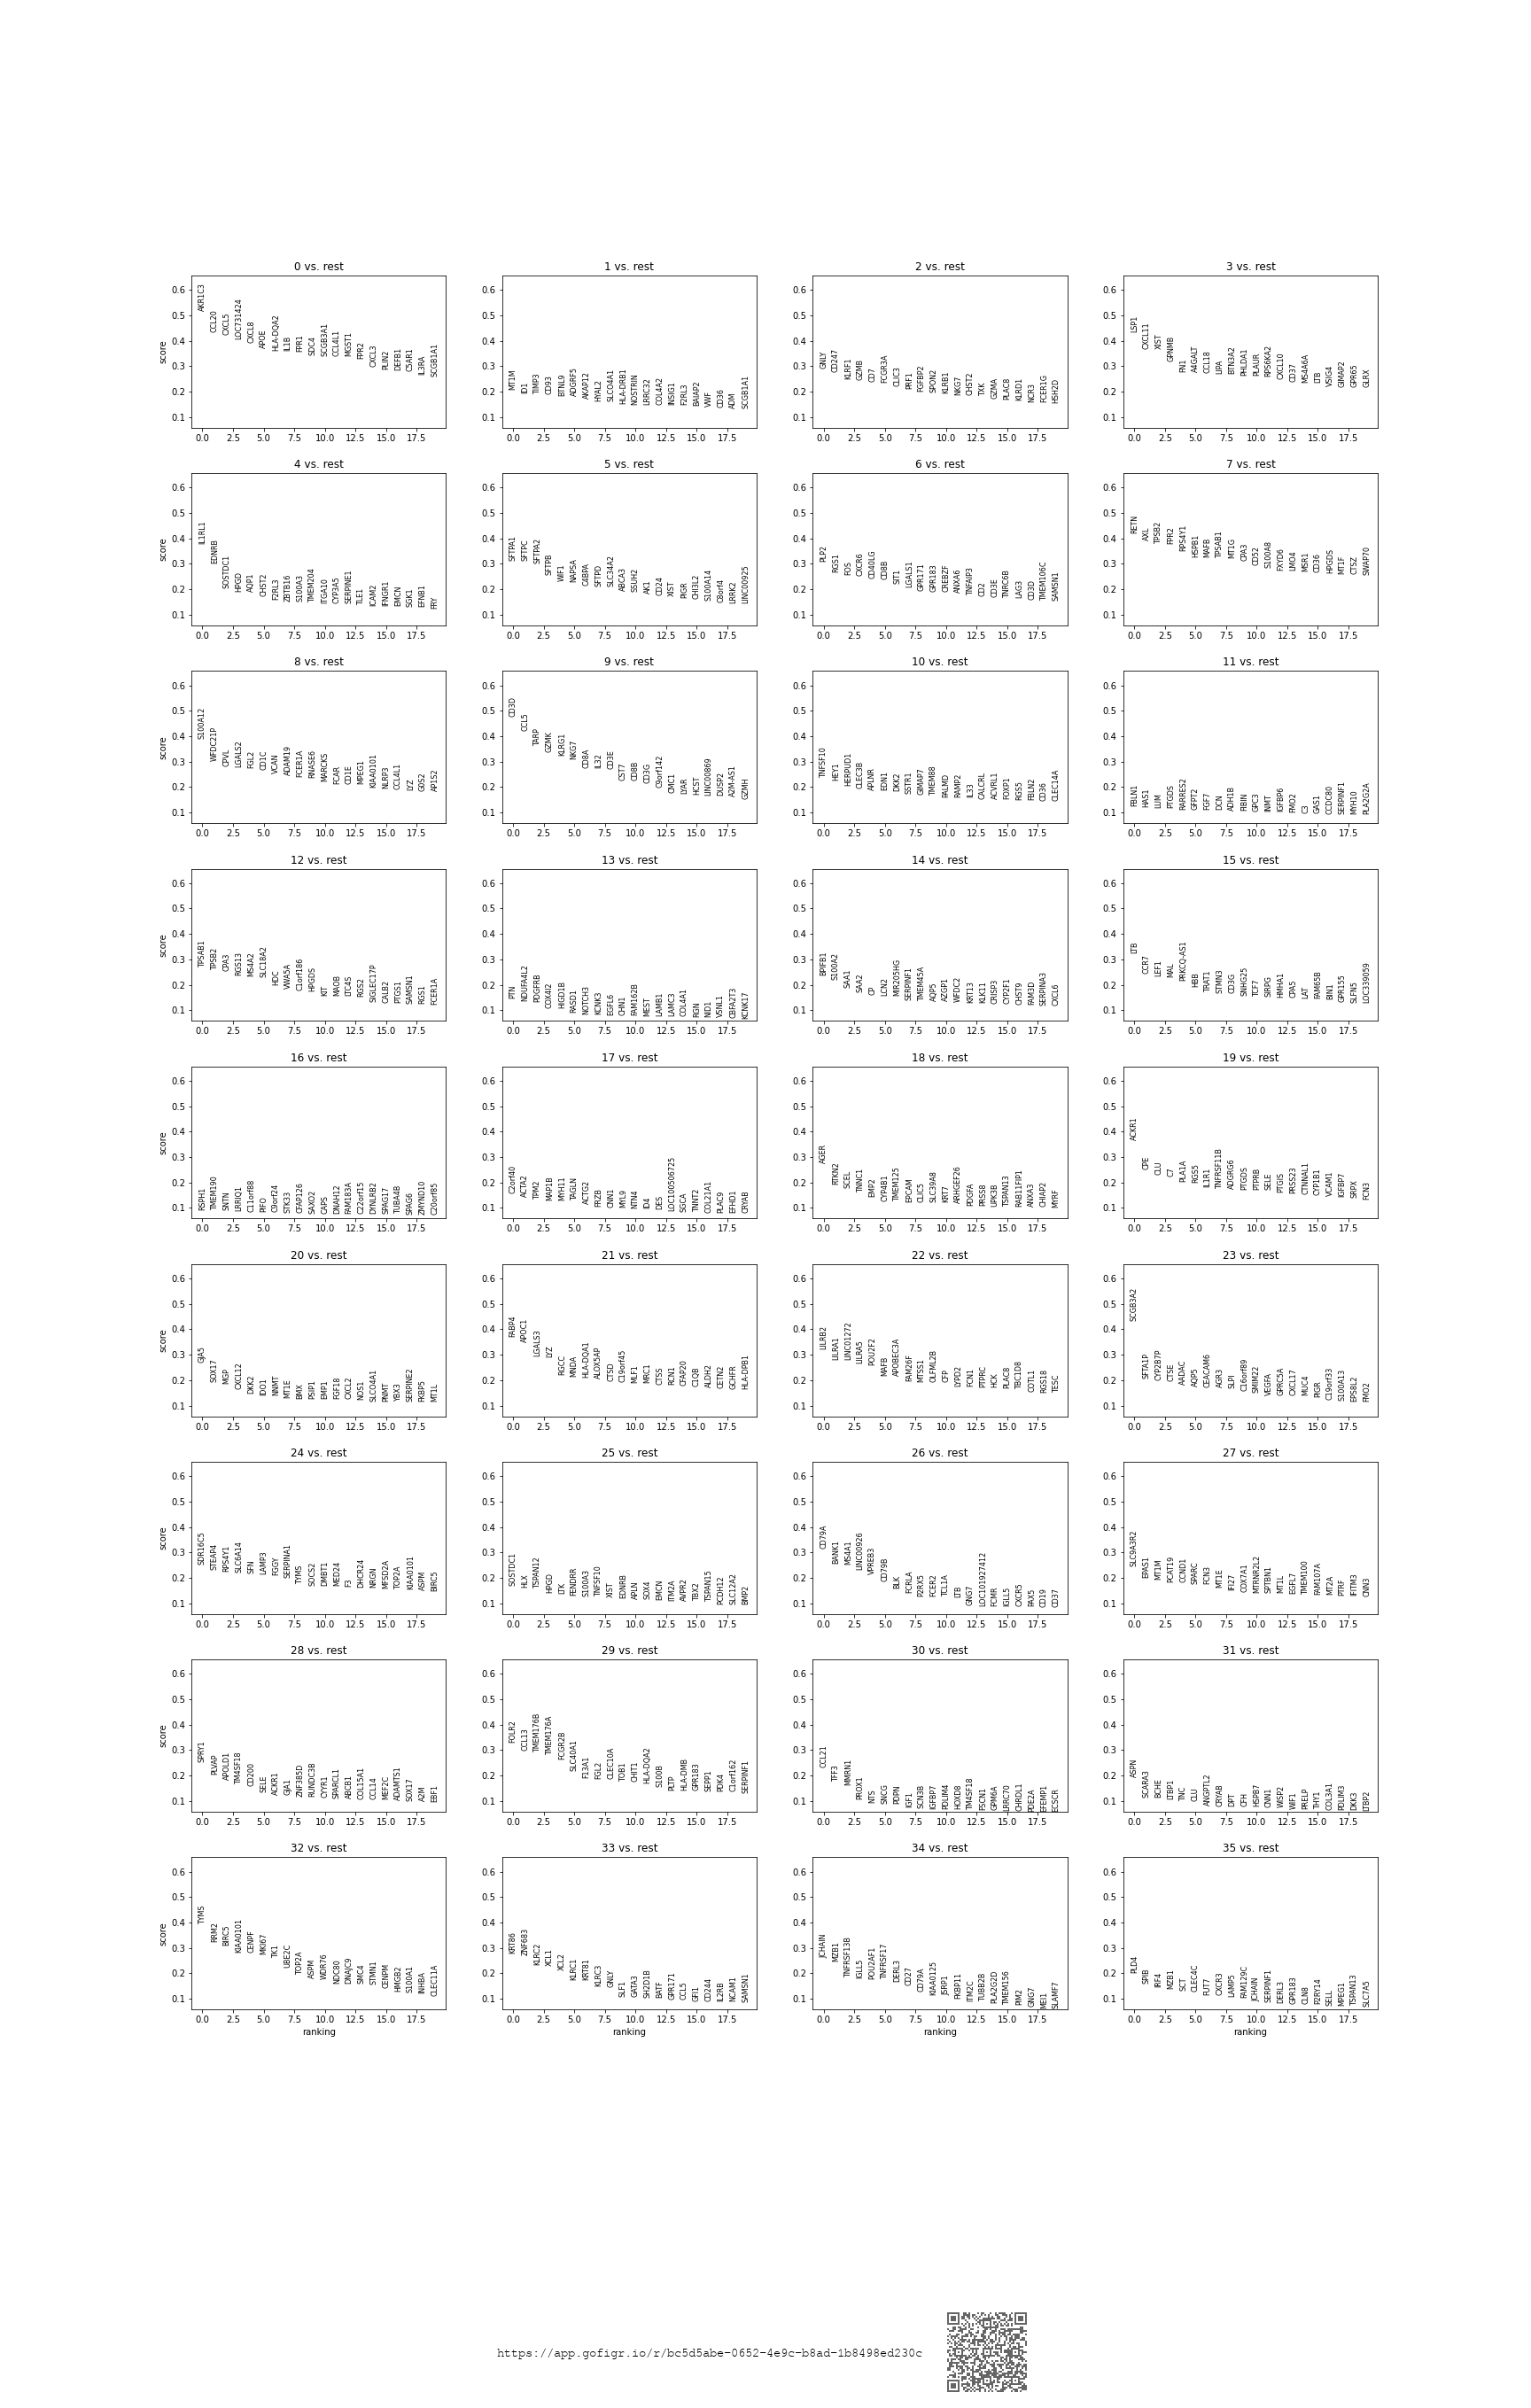
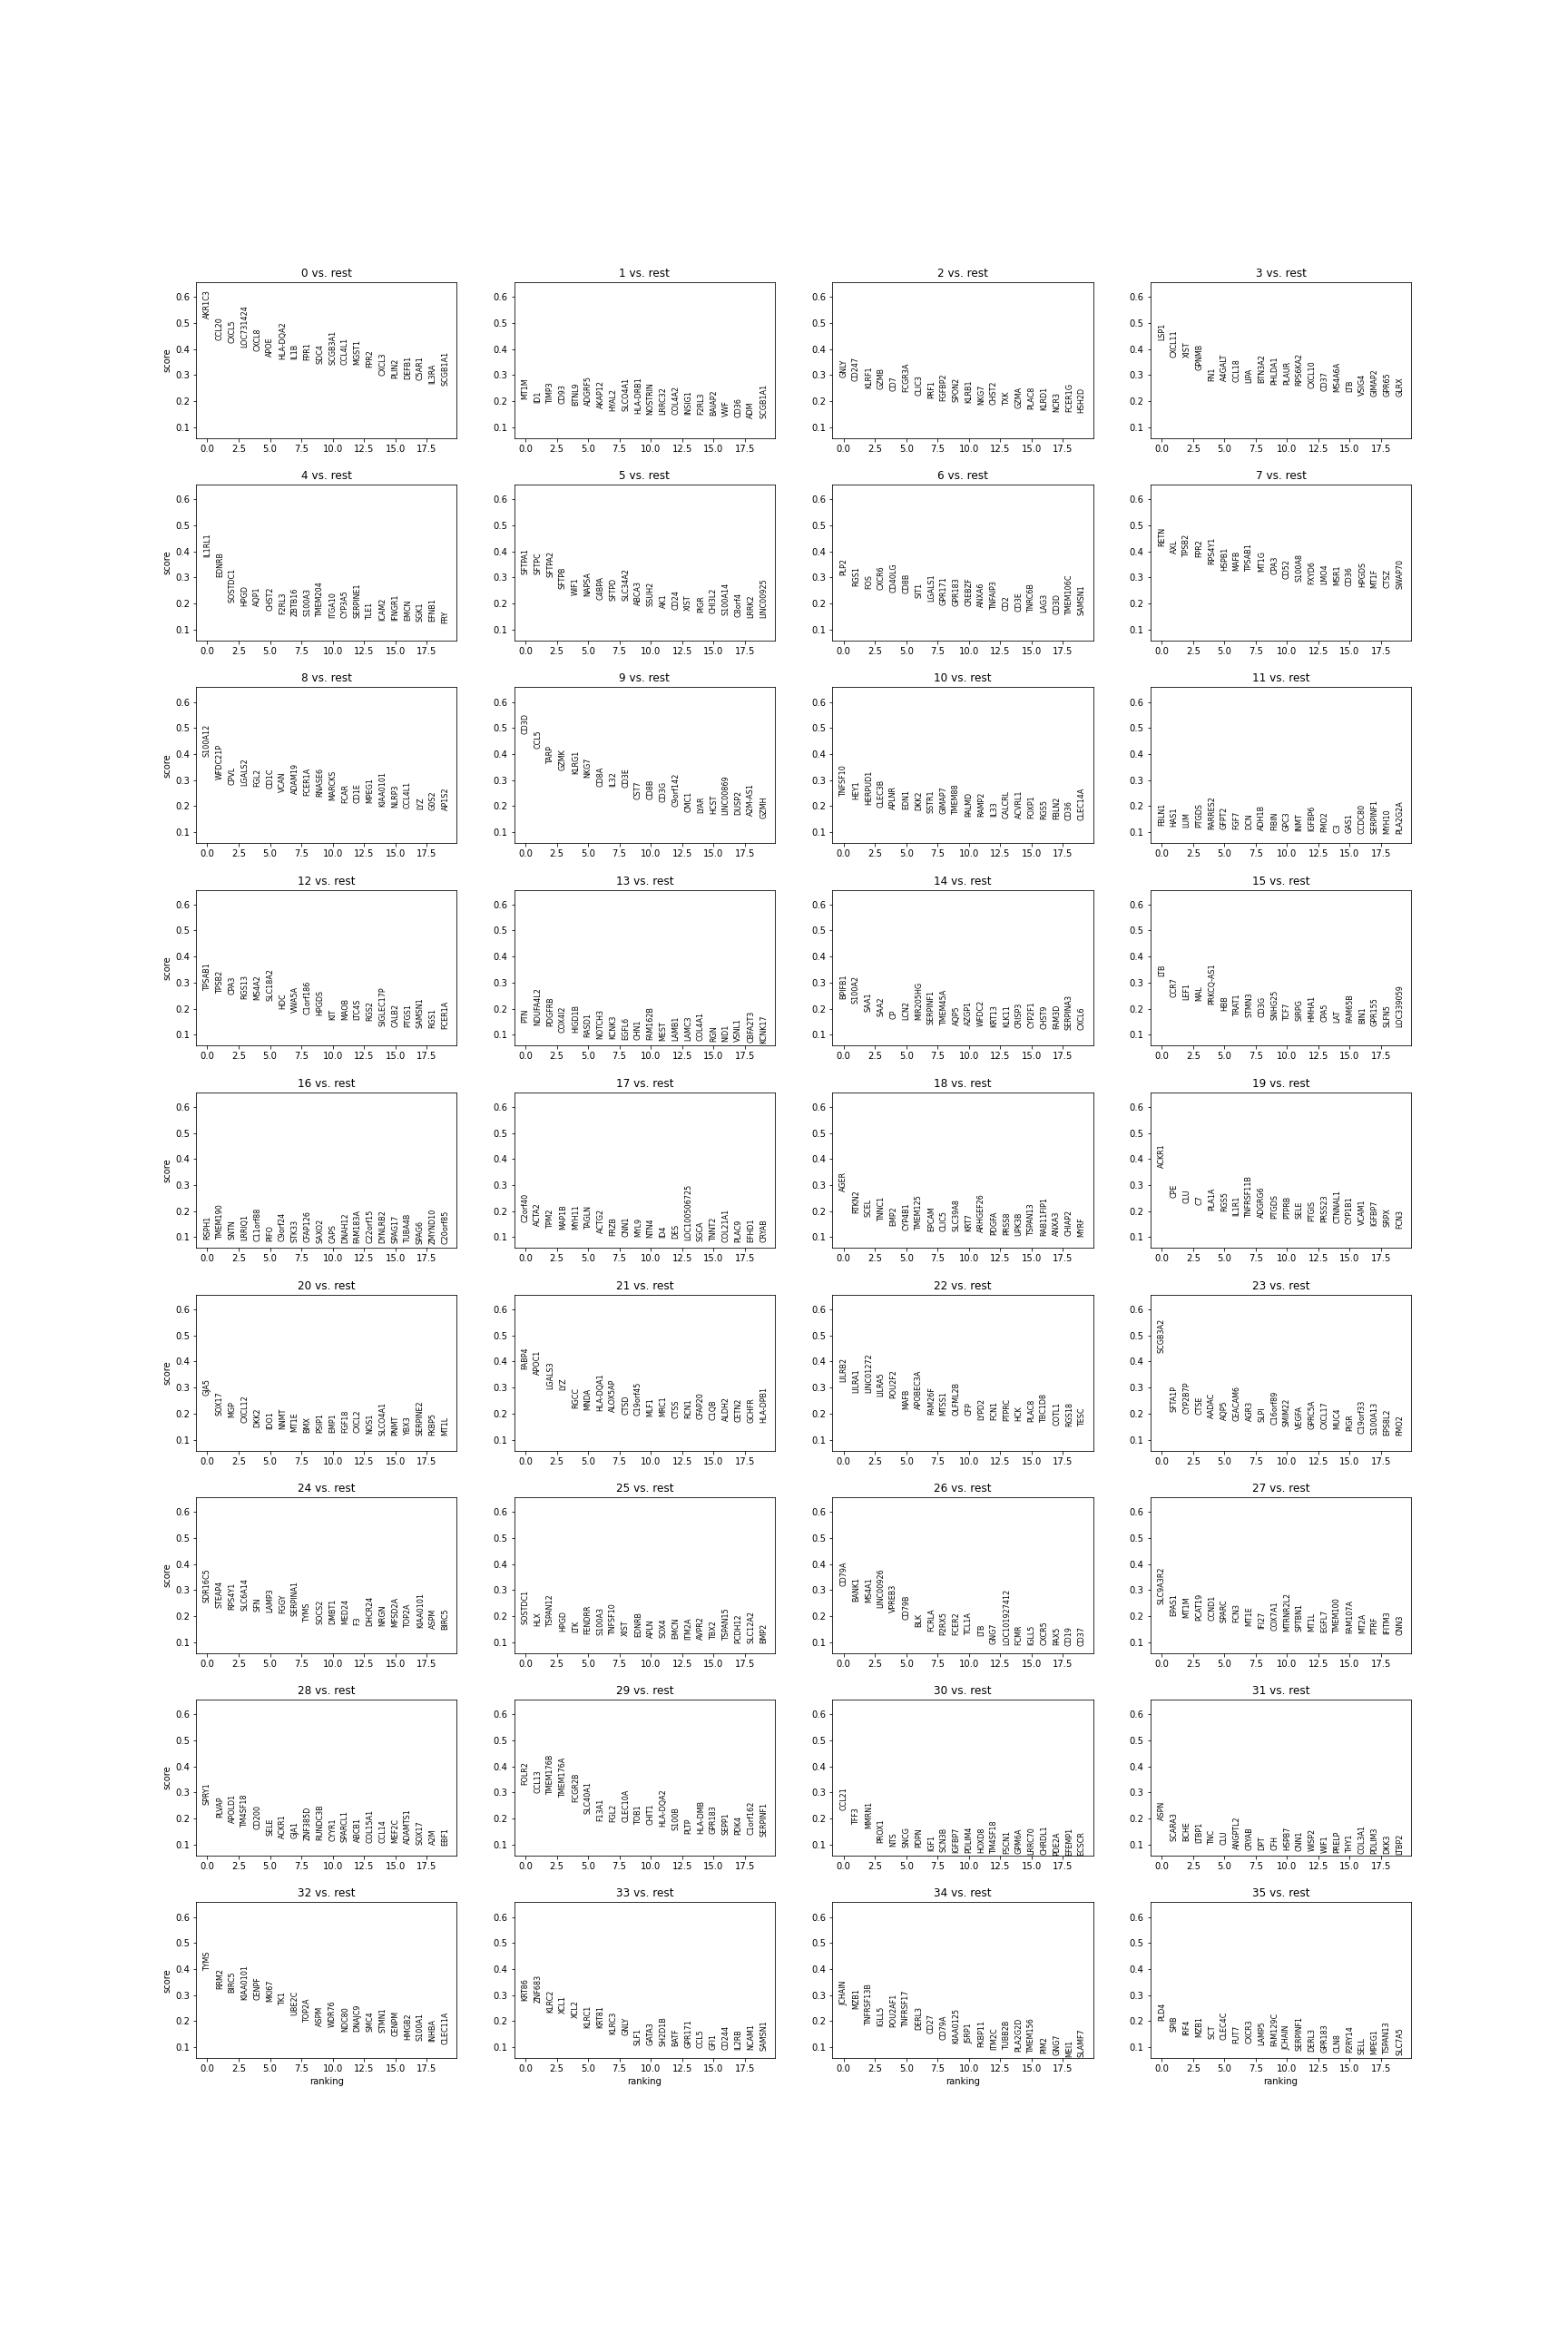

CPU times: user 8.34 s, sys: 353 ms, total: 8.69 s
Wall time: 12 s


In [32]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create zoomed-in view

In [33]:
reanalysis_start = time.time()

In [34]:
%%time

adata = adata[adata.obs["EPCAM_raw"] > 0.0, :]
print(adata.X.shape)

(7958, 5000)
CPU times: user 70 ms, sys: 17 ms, total: 87 ms
Wall time: 86.1 ms


In [35]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 33.5 s, sys: 17.9 s, total: 51.5 s
Wall time: 22.9 s


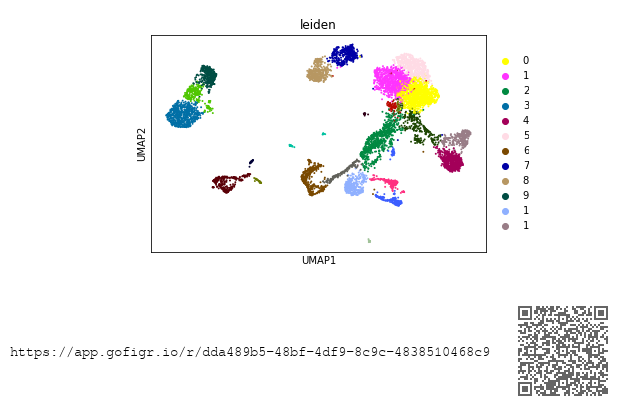


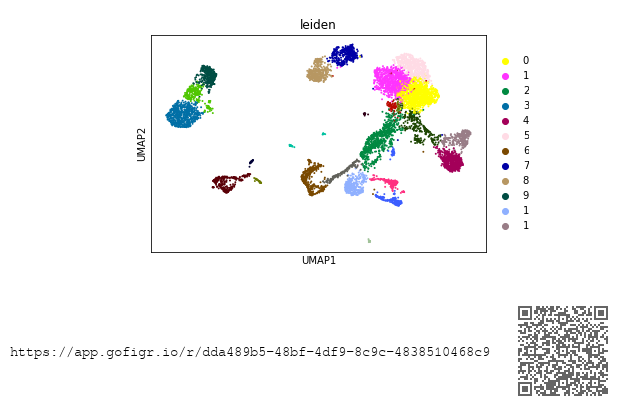
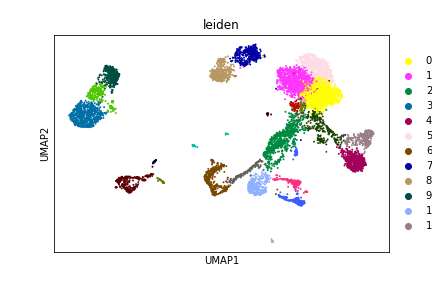
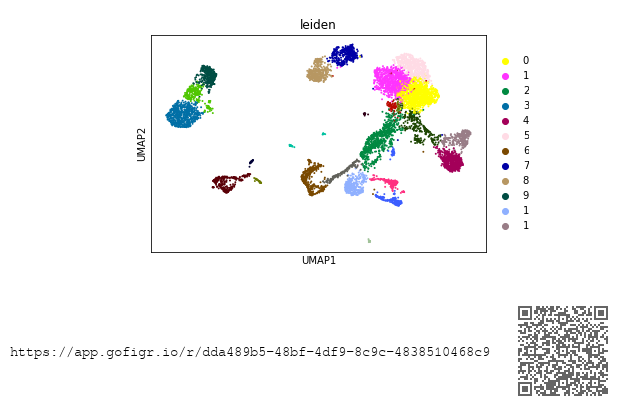
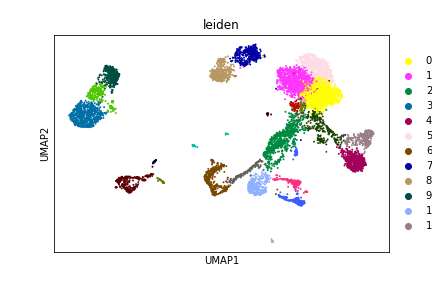

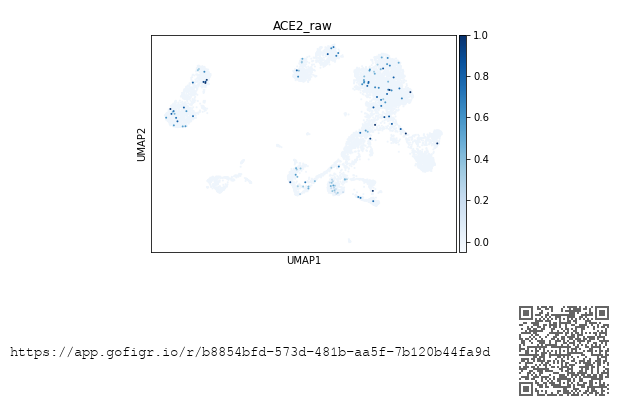


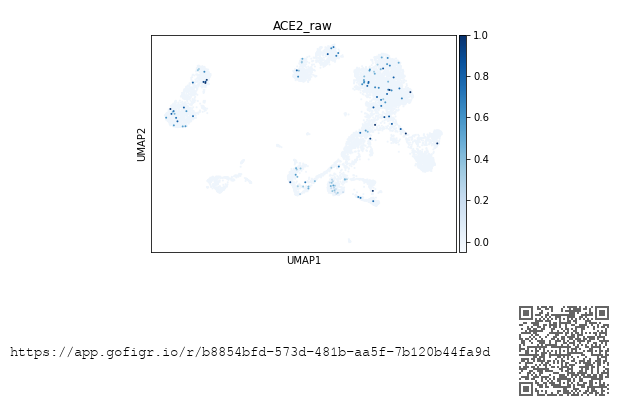
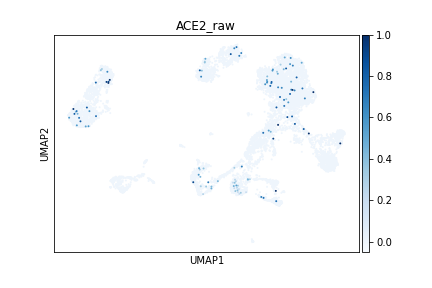
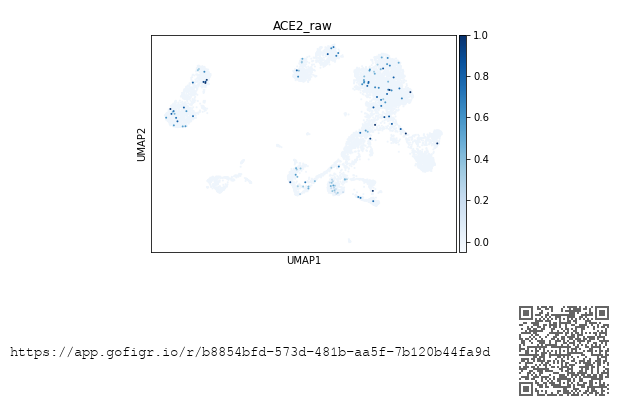
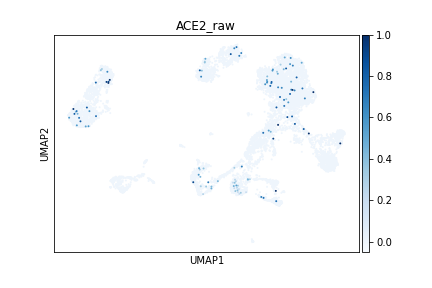

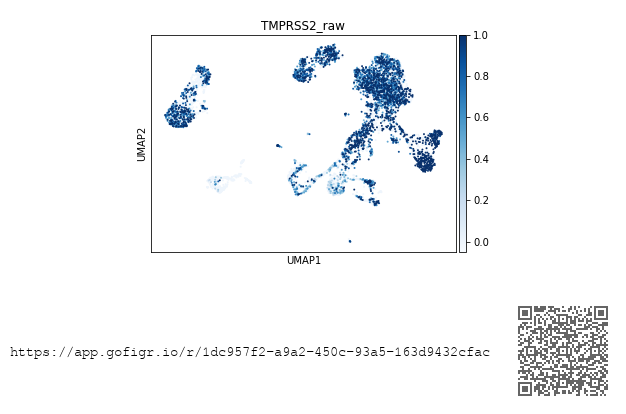


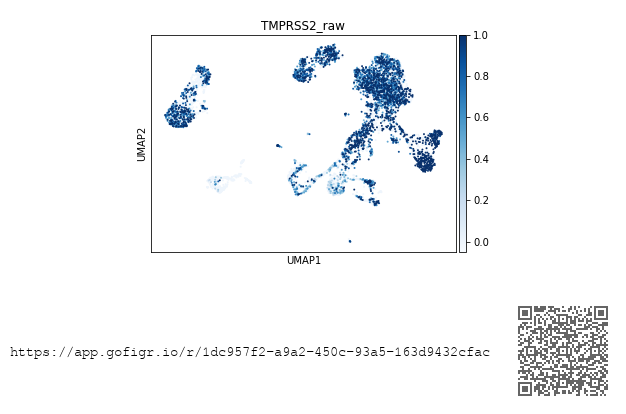
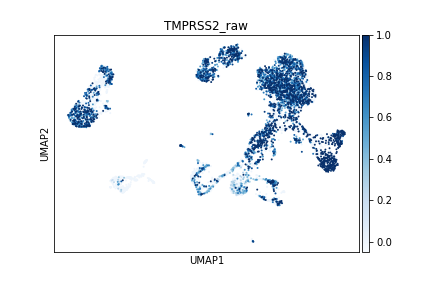
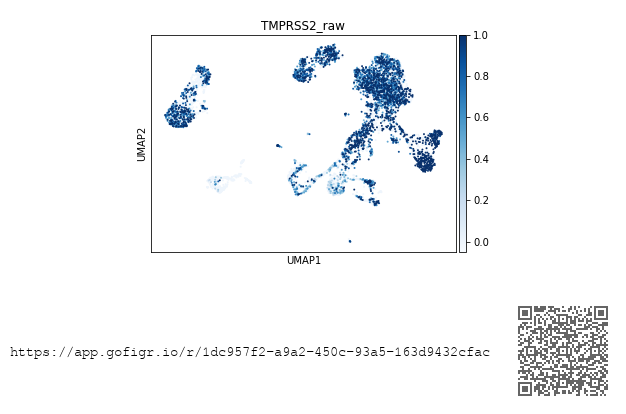
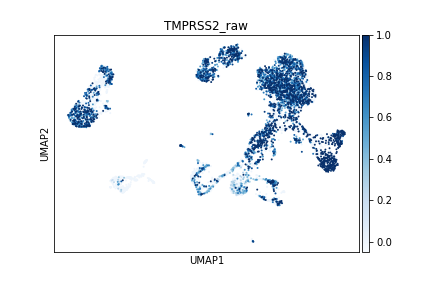

CPU times: user 3.33 s, sys: 107 ms, total: 3.44 s
Wall time: 10.9 s


In [36]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [37]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 33.85128998756409


In [38]:
print("Full time: %s" % (time.time() - start))

Full time: 866.4590137004852
